# Solar Flare Nanoflare Detection Analysis

This notebook analyzes GOES X-ray sensor data to detect nanoflares using enhanced visualizations and curve fitting techniques.

## Objectives:
- Load and truncate the 2022 XRSA/XRSB flux data to 200 samples
- Create enhanced visualizations using Seaborn
- Plot log-scale flux vs time for both XRSA and XRSB channels
- Implement curve fitting to detect nanoflare signatures
- Identify potential nanoflare events

In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for enhanced visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

print("Libraries imported successfully!")

Libraries imported successfully!


In [31]:
# Load the CSV data
data_path = 'data/2023_xrsa_xrsb.csv'
df = pd.read_csv(data_path)

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Original dataset shape: (525600, 4)
Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

First few rows:
   time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
0             0             0        8.923480e-08            0.000002
1             1            60        8.247599e-08            0.000001
2             2           120        7.758199e-08            0.000001
3             3           180        7.542049e-08            0.000001
4             4           240        7.351816e-08            0.000001

Missing values:
time_minutes              0
time_seconds              0
xrsa_flux_observed    16181
xrsb_flux_observed    16181
dtype: int64


In [32]:
# Clean the data and remove rows with missing values
df_clean = df.dropna()
print(f"Dataset shape after removing NaN values: {df_clean.shape}")

# Truncate to 1300 to 2000 samples as requested
df_truncated = df_clean.iloc[1300:2000].copy()
#df_truncated = df_clean.head(2000).copy()
print(f"Truncated dataset shape: {df_truncated.shape}")

# Display basic statistics
print("\nBasic statistics of truncated dataset:")
print(df_truncated.describe())

Dataset shape after removing NaN values: (509419, 4)
Truncated dataset shape: (700, 4)

Basic statistics of truncated dataset:
       time_minutes   time_seconds  xrsa_flux_observed  xrsb_flux_observed
count     700.00000     700.000000        7.000000e+02        7.000000e+02
mean     1649.50000   98970.000000        8.108224e-08        1.155024e-06
std       202.21688   12133.012816        1.124036e-07        8.324168e-07
min      1300.00000   78000.000000        3.880740e-08        7.902805e-07
25%      1474.75000   88485.000000        5.089853e-08        8.593487e-07
50%      1649.50000   98970.000000        5.950158e-08        9.634299e-07
75%      1824.25000  109455.000000        7.302822e-08        1.072696e-06
max      1999.00000  119940.000000        1.312610e-06        9.515483e-06


In [33]:
# Prepare data for analysis
time_minutes = df_truncated['time_minutes'].values
xrsa_flux = df_truncated['xrsa_flux_observed'].values
xrsb_flux = df_truncated['xrsb_flux_observed'].values

# Calculate log values (handle potential zero or negative values)
# Add small epsilon to avoid log(0)
epsilon = 1e-12
log_xrsa = np.log10(np.maximum(xrsa_flux, epsilon))
log_xrsb = np.log10(np.maximum(xrsb_flux, epsilon))

print(f"Time range: {time_minutes.min():.1f} to {time_minutes.max():.1f} minutes")
print(f"XRSA flux range: {xrsa_flux.min():.2e} to {xrsa_flux.max():.2e}")
print(f"XRSB flux range: {xrsb_flux.min():.2e} to {xrsb_flux.max():.2e}")
print(f"Log XRSA range: {log_xrsa.min():.2f} to {log_xrsa.max():.2f}")
print(f"Log XRSB range: {log_xrsb.min():.2f} to {log_xrsb.max():.2f}")

Time range: 1300.0 to 1999.0 minutes
XRSA flux range: 3.88e-08 to 1.31e-06
XRSB flux range: 7.90e-07 to 9.52e-06
Log XRSA range: -7.41 to -5.88
Log XRSB range: -6.10 to -5.02


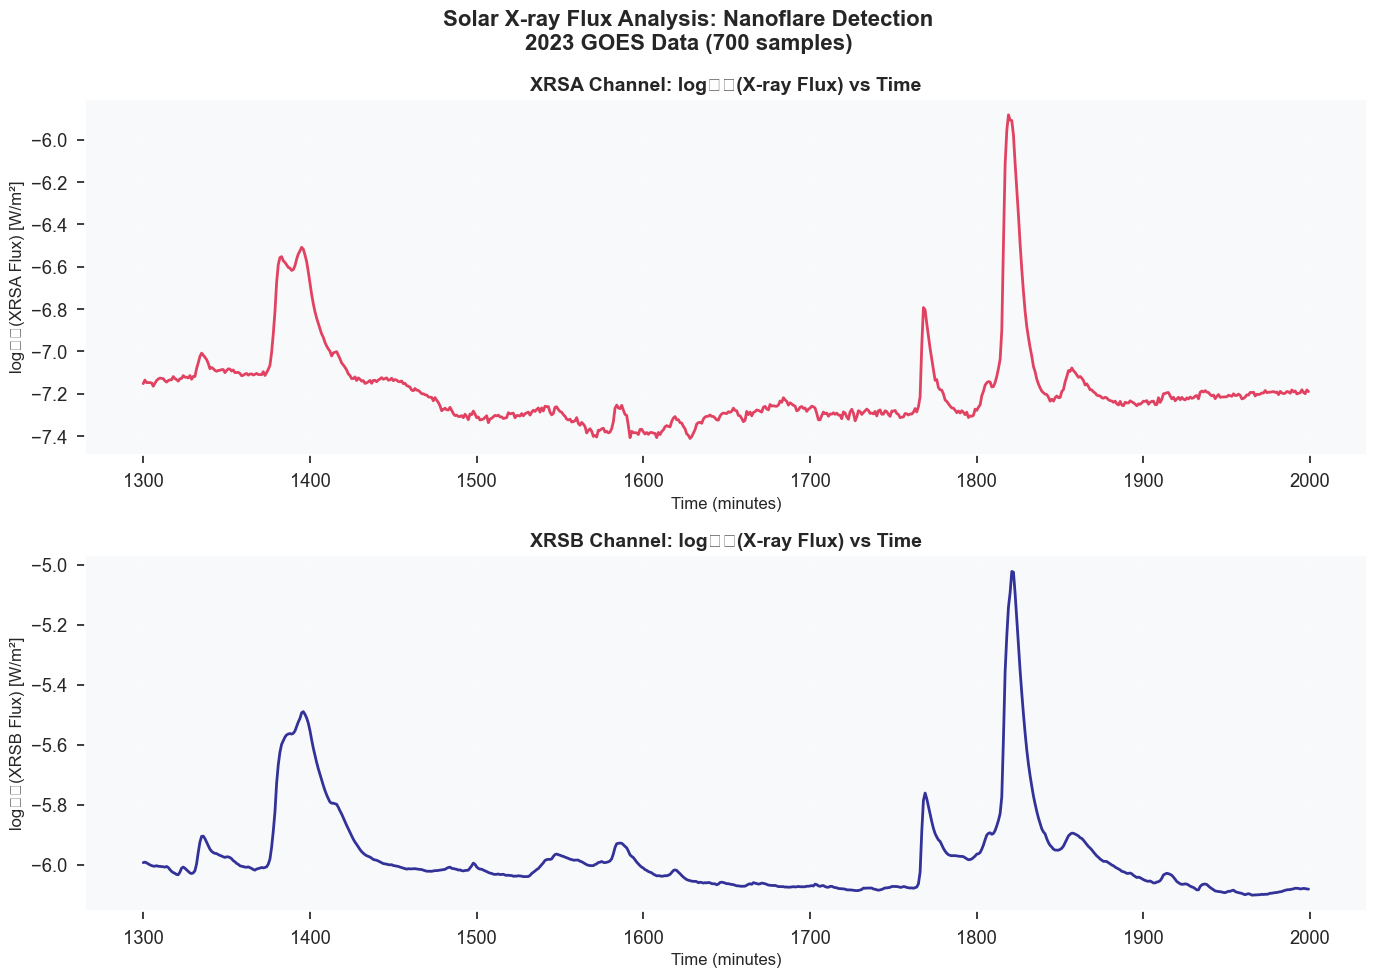

Enhanced visualization created successfully!


In [34]:
# Create enhanced visualizations using Seaborn
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Solar X-ray Flux Analysis: Nanoflare Detection\n2023 GOES Data (700 samples)', 
             fontsize=16, fontweight='bold')

# Plot 1: log(XRSA flux) vs time
sns.lineplot(x=time_minutes, y=log_xrsa, ax=axes[0], 
             color='crimson', linewidth=2, alpha=0.8)
axes[0].set_title('XRSA Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (minutes)', fontsize=12)
axes[0].set_ylabel('log₁₀(XRSA Flux) [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# Plot 2: log(XRSB flux) vs time
sns.lineplot(x=time_minutes, y=log_xrsb, ax=axes[1], 
             color='navy', linewidth=2, alpha=0.8)
axes[1].set_title('XRSB Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (minutes)', fontsize=12)
axes[1].set_ylabel('log₁₀(XRSB Flux) [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

print("Enhanced visualization created successfully!")

Now I want to flat the baseline of (log(xrsa) vs time ) using baseline correction . 


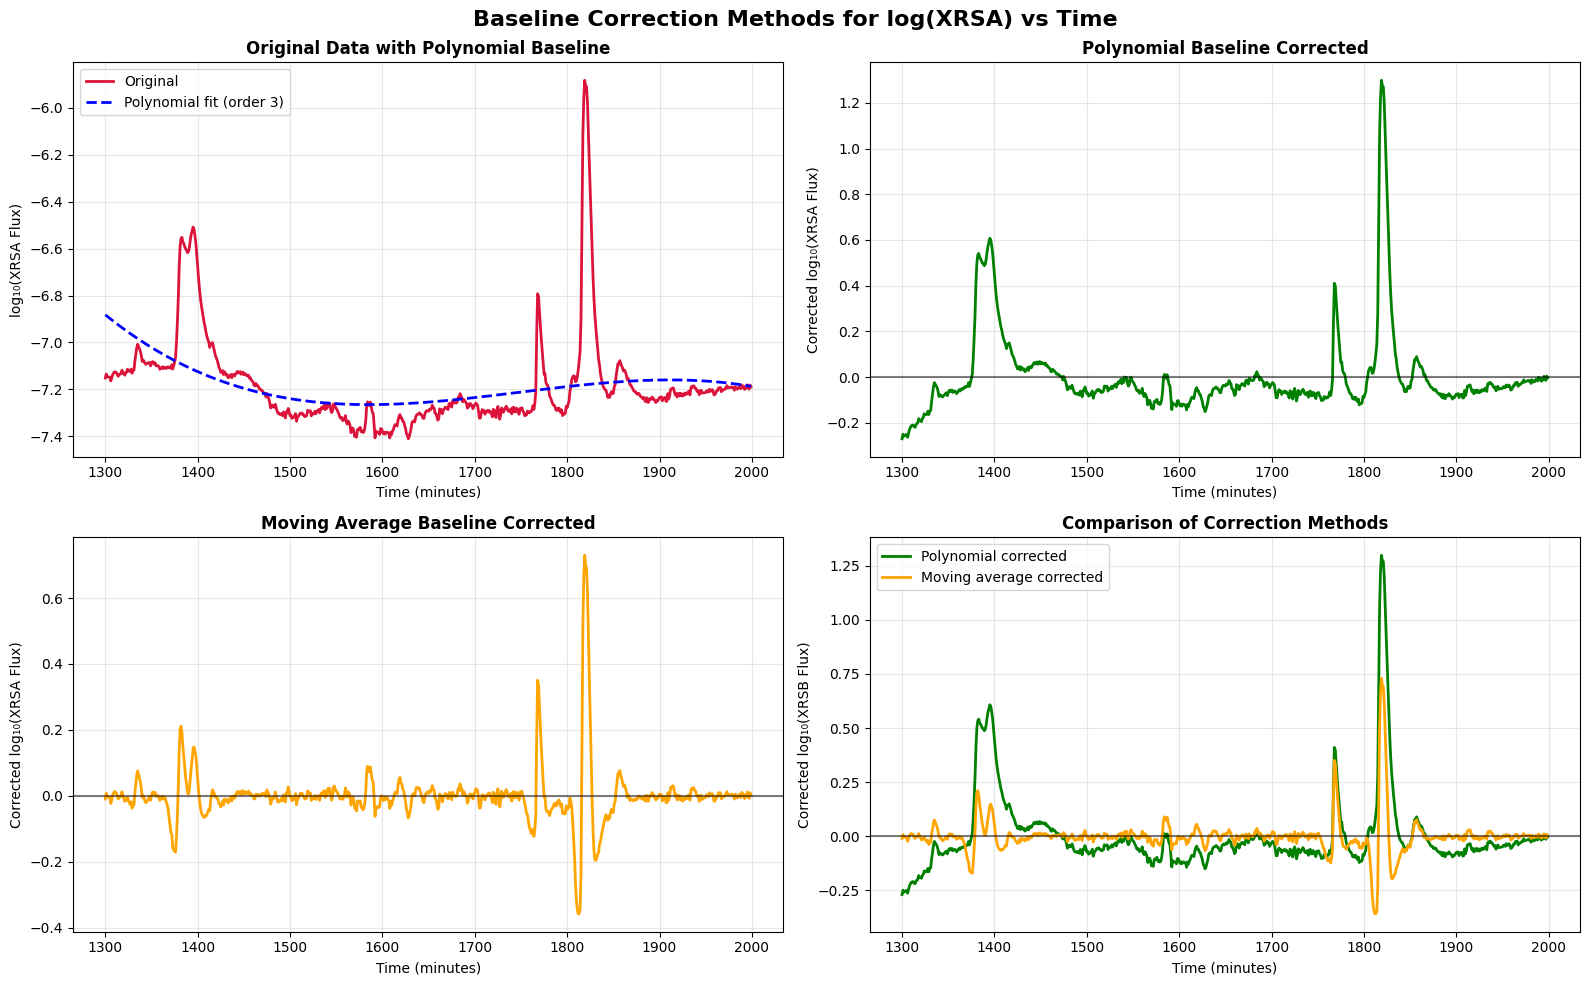

BASELINE CORRECTION RESULTS:
Original data - Mean: -7.181106, Std: 0.205621
Polynomial corrected - Mean: 0.000000, Std: 0.188668
Moving average corrected - Mean: 0.000000, Std: 0.088001

Baseline correction completed! Using polynomial method (order 3)


In [69]:
from scipy.signal import detrend
from scipy.ndimage import uniform_filter1d

# Baseline correction for log(XRSA) data

# Method 1: Polynomial baseline correction
# Fit a higher-order polynomial to remove baseline drift
poly_order = 3
baseline_poly = np.polyfit(time_minutes, log_xrsa, poly_order)
baseline_fit = np.polyval(baseline_poly, time_minutes)
log_xrsa_corrected_poly = log_xrsa - baseline_fit

# Method 2: Moving average baseline correction
# Use a moving average to estimate the baseline
window_size = 25  # Adjust based on your data characteristics
baseline_moving = uniform_filter1d(log_xrsa, size=window_size)
log_xrsa_corrected_moving = log_xrsa - baseline_moving



# Create visualization of baseline correction methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Baseline Correction Methods for log(XRSA) vs Time', fontsize=16, fontweight='bold')

# Original data
axes[0,0].plot(time_minutes, log_xrsa, color='crimson', linewidth=2, label='Original')
axes[0,0].plot(time_minutes, baseline_fit, color='blue', linestyle='--', linewidth=2, label=f'Polynomial fit (order {poly_order})')
axes[0,0].set_title('Original Data with Polynomial Baseline', fontweight='bold')
axes[0,0].set_xlabel('Time (minutes)')
axes[0,0].set_ylabel('log₁₀(XRSA Flux)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Polynomial corrected
axes[0,1].plot(time_minutes, log_xrsa_corrected_poly, color='green', linewidth=2)
axes[0,1].set_title('Polynomial Baseline Corrected', fontweight='bold')
axes[0,1].set_xlabel('Time (minutes)')
axes[0,1].set_ylabel('Corrected log₁₀(XRSA Flux)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Moving average corrected
axes[1,0].plot(time_minutes, log_xrsa_corrected_moving, color='orange', linewidth=2)
axes[1,0].set_title('Moving Average Baseline Corrected', fontweight='bold')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('Corrected log₁₀(XRSA Flux)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Comparison of both methods
axes[1,1].plot(time_minutes, log_xrsa_corrected_poly, color='green', linewidth=2, label='Polynomial corrected')
axes[1,1].plot(time_minutes, log_xrsa_corrected_moving, color='orange', linewidth=2, label='Moving average corrected')
axes[1,1].set_title('Comparison of Correction Methods', fontweight='bold')
axes[1,1].set_xlabel('Time (minutes)')
axes[1,1].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics for each method
print("BASELINE CORRECTION RESULTS:")
print("=" * 50)
print(f"Original data - Mean: {np.mean(log_xrsa):.6f}, Std: {np.std(log_xrsa):.6f}")
print(f"Polynomial corrected - Mean: {np.mean(log_xrsa_corrected_poly):.6f}, Std: {np.std(log_xrsa_corrected_poly):.6f}")
print(f"Moving average corrected - Mean: {np.mean(log_xrsa_corrected_moving):.6f}, Std: {np.std(log_xrsa_corrected_moving):.6f}")

# Store the best corrected version for further analysis
log_xrsa_flattened = log_xrsa_corrected_poly  # Using polynomial correction as default
print(f"\nBaseline correction completed! Using polynomial method (order {poly_order})")

also baseline correction to log(xrsb) vs time 

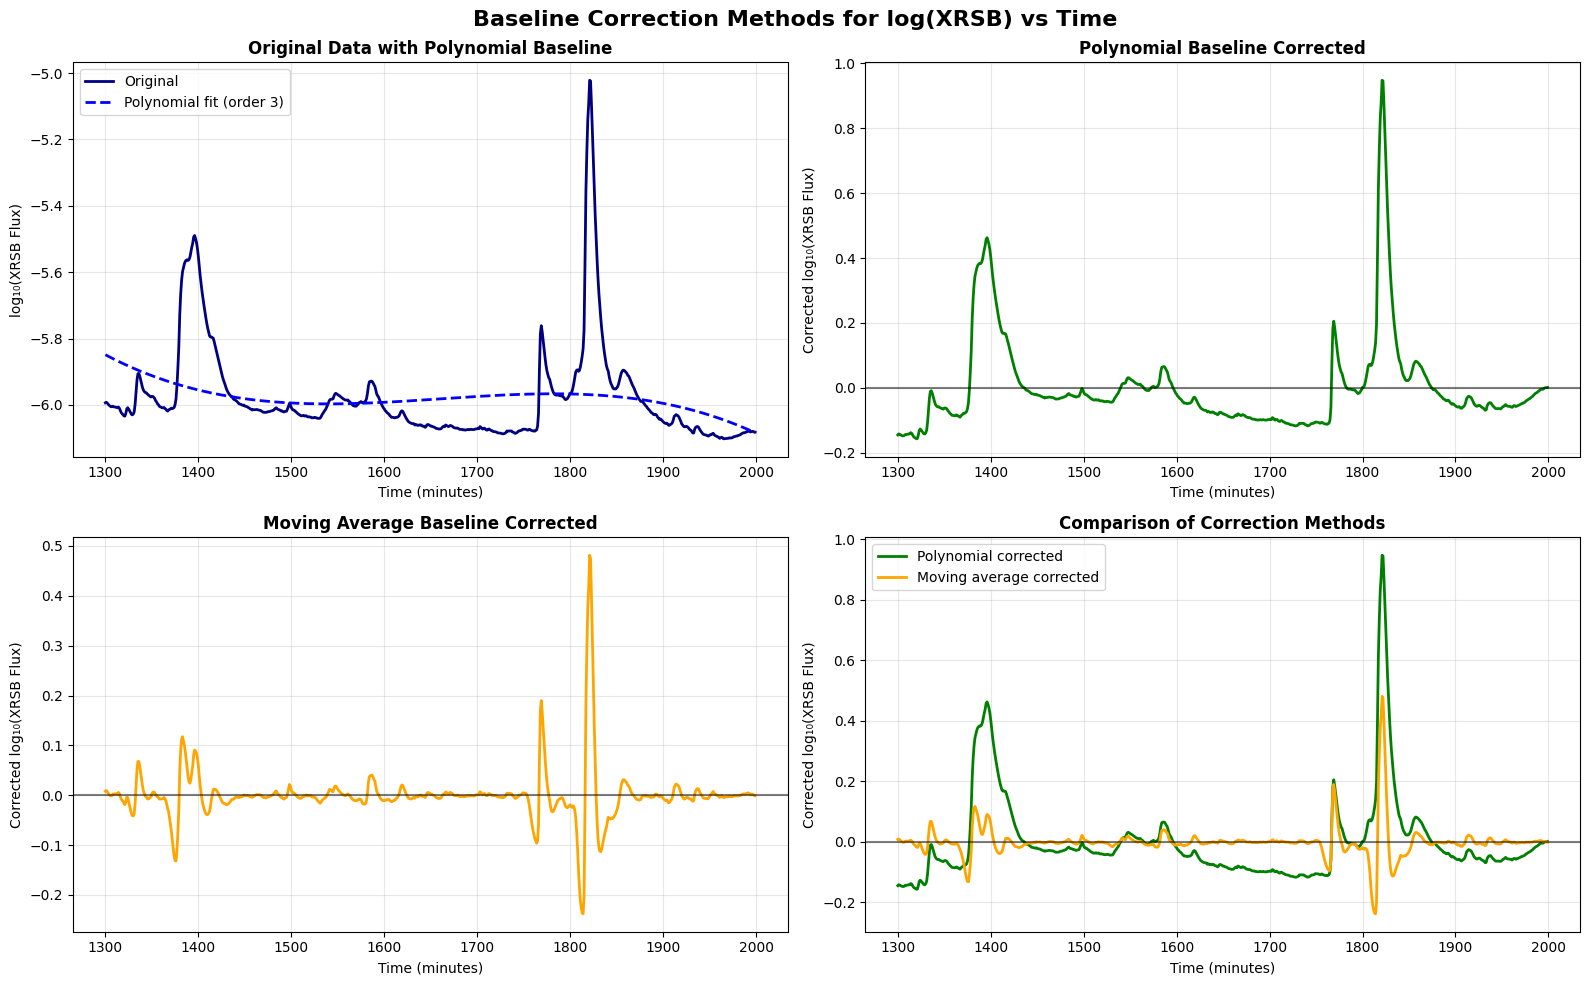

XRSB BASELINE CORRECTION RESULTS:
Original data - Mean: -5.977991, Std: 0.151554
Polynomial corrected - Mean: 0.000000, Std: 0.146652
Moving average corrected - Mean: 0.000000, Std: 0.055559

XRSB baseline correction completed! Using polynomial method (order 3)


In [68]:
# Baseline correction for log(XRSB) data

# Method 1: Polynomial baseline correction
# Fit a higher-order polynomial to remove baseline drift
poly_order = 3
baseline_poly_xrsb = np.polyfit(time_minutes, log_xrsb, poly_order)
baseline_fit_xrsb = np.polyval(baseline_poly_xrsb, time_minutes)
log_xrsb_corrected_poly = log_xrsb - baseline_fit_xrsb

# Method 2: Moving average baseline correction
# Use a moving average to estimate the baseline
window_size = 25  # Adjust based on your data characteristics
baseline_moving_xrsb = uniform_filter1d(log_xrsb, size=window_size)
log_xrsb_corrected_moving = log_xrsb - baseline_moving_xrsb

# Create visualization of baseline correction methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Baseline Correction Methods for log(XRSB) vs Time', fontsize=16, fontweight='bold')

# Original data
axes[0,0].plot(time_minutes, log_xrsb, color='navy', linewidth=2, label='Original')
axes[0,0].plot(time_minutes, baseline_fit_xrsb, color='blue', linestyle='--', linewidth=2, label=f'Polynomial fit (order {poly_order})')
axes[0,0].set_title('Original Data with Polynomial Baseline', fontweight='bold')
axes[0,0].set_xlabel('Time (minutes)')
axes[0,0].set_ylabel('log₁₀(XRSB Flux)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Polynomial corrected
axes[0,1].plot(time_minutes, log_xrsb_corrected_poly, color='green', linewidth=2)
axes[0,1].set_title('Polynomial Baseline Corrected', fontweight='bold')
axes[0,1].set_xlabel('Time (minutes)')
axes[0,1].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Moving average corrected
axes[1,0].plot(time_minutes, log_xrsb_corrected_moving, color='orange', linewidth=2)
axes[1,0].set_title('Moving Average Baseline Corrected', fontweight='bold')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Comparison of both methods
axes[1,1].plot(time_minutes, log_xrsb_corrected_poly, color='green', linewidth=2, label='Polynomial corrected')
axes[1,1].plot(time_minutes, log_xrsb_corrected_moving, color='orange', linewidth=2, label='Moving average corrected')
axes[1,1].set_title('Comparison of Correction Methods', fontweight='bold')
axes[1,1].set_xlabel('Time (minutes)')
axes[1,1].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics for each method
print("XRSB BASELINE CORRECTION RESULTS:")
print("=" * 50)
print(f"Original data - Mean: {np.mean(log_xrsb):.6f}, Std: {np.std(log_xrsb):.6f}")
print(f"Polynomial corrected - Mean: {np.mean(log_xrsb_corrected_poly):.6f}, Std: {np.std(log_xrsb_corrected_poly):.6f}")
print(f"Moving average corrected - Mean: {np.mean(log_xrsb_corrected_moving):.6f}, Std: {np.std(log_xrsb_corrected_moving):.6f}")

# Store the best corrected version for further analysis
log_xrsb_flattened = log_xrsb_corrected_poly  # Using polynomial correction as default
print(f"\nXRSB baseline correction completed! Using polynomial method (order {poly_order})")

now , use savgol filter to Smooth noisy signals without distorting peak shapes on the baseline correction on XRSA

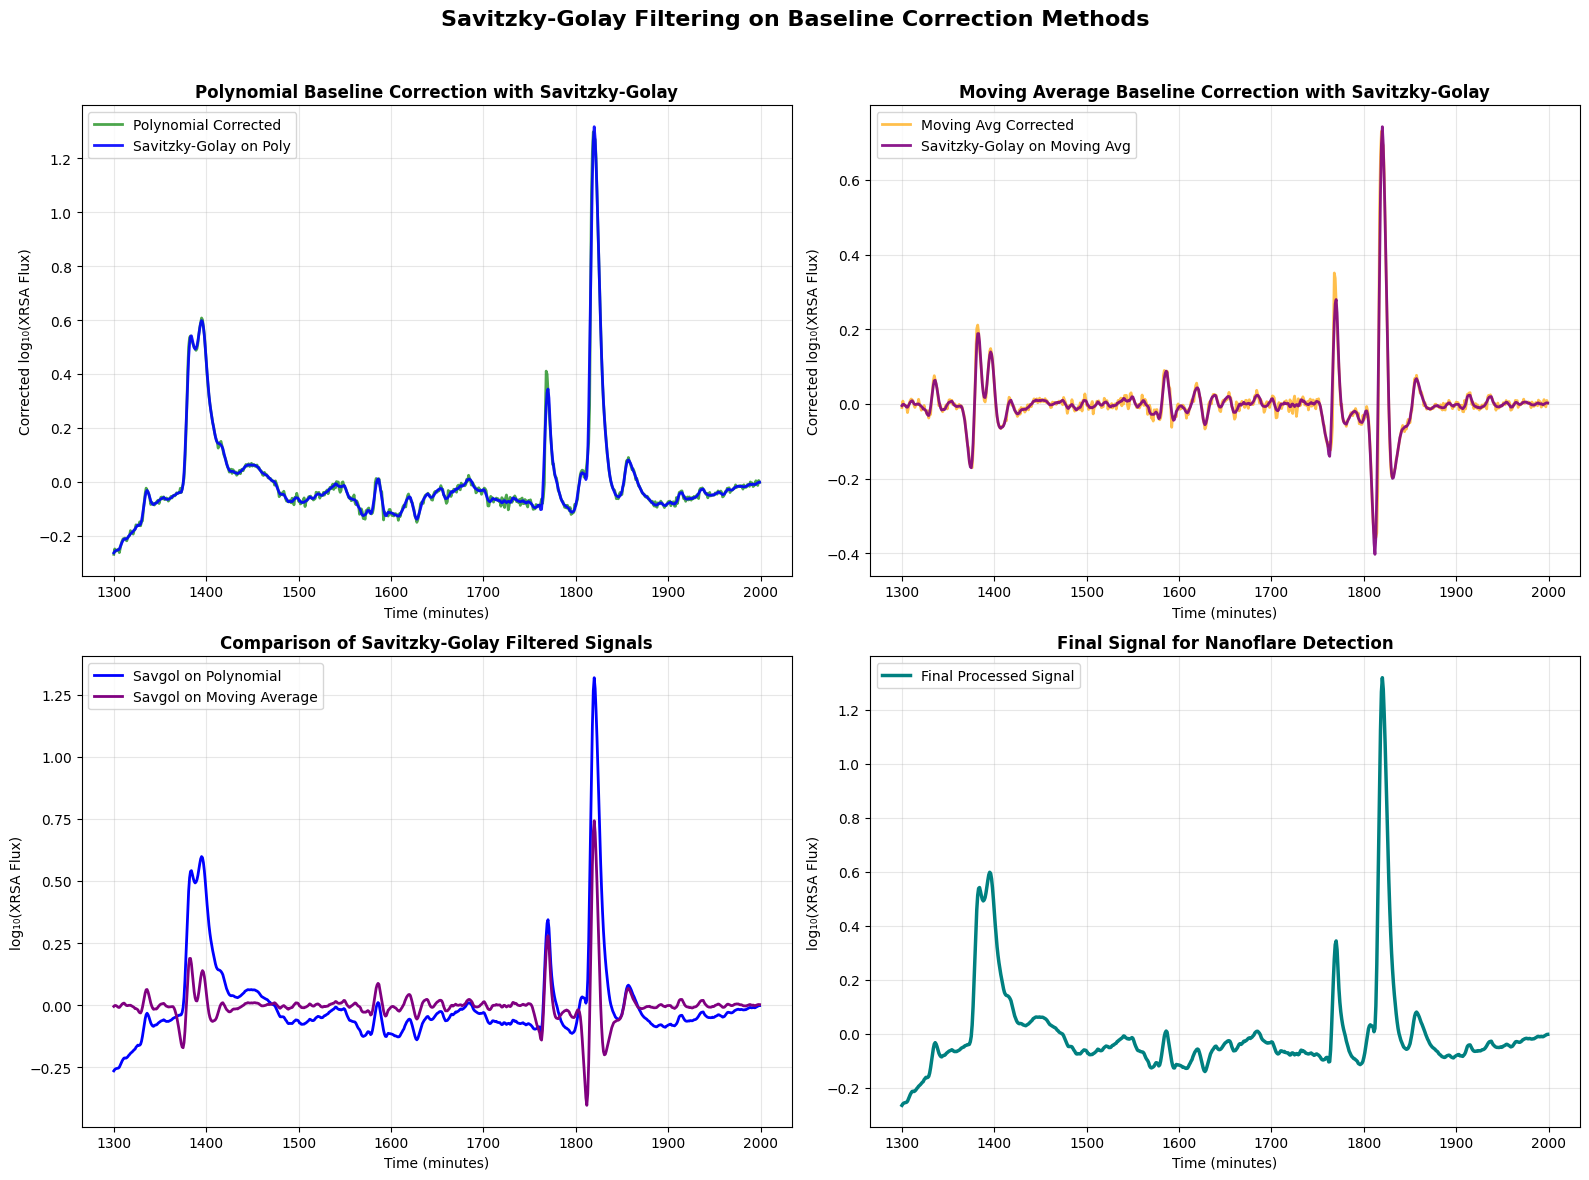

SAVITZKY-GOLAY FILTERING ANALYSIS:
Filter parameters: Window=11, Order=3
Std Dev (Poly Corrected): 0.188668
Std Dev (Savgol on Poly): 0.186830
Std Dev (Moving Avg Corrected): 0.088001
Std Dev (Savgol on Moving Avg): 0.083788

Final signal selected from polynomial correction + Savitzky-Golay.


In [64]:
from scipy.signal import savgol_filter

# Savitzky-Golay filter parameters
window_length = 11  # Must be odd, controls smoothing
polyorder = 3       # Polynomial order, should be less than window_length

# Apply Savitzky-Golay filter to both baseline-corrected signals
log_xrsa_savgol_poly = savgol_filter(log_xrsa_corrected_poly, window_length, polyorder)
log_xrsa_savgol_moving = savgol_filter(log_xrsa_corrected_moving, window_length, polyorder)

# Create visualization comparing the results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Savitzky-Golay Filtering on Baseline Correction Methods', fontsize=16, fontweight='bold')

# Plot 1: Polynomial Correction + Savitzky-Golay
axes[0, 0].plot(time_minutes, log_xrsa_corrected_poly, color='green', linewidth=2, alpha=0.7, label='Polynomial Corrected')
axes[0, 0].plot(time_minutes, log_xrsa_savgol_poly, color='blue', linewidth=2, alpha=0.9, label='Savitzky-Golay on Poly')
axes[0, 0].set_title('Polynomial Baseline Correction with Savitzky-Golay', fontweight='bold')
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Corrected log₁₀(XRSA Flux)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Moving Average Correction + Savitzky-Golay
axes[0, 1].plot(time_minutes, log_xrsa_corrected_moving, color='orange', linewidth=2, alpha=0.7, label='Moving Avg Corrected')
axes[0, 1].plot(time_minutes, log_xrsa_savgol_moving, color='purple', linewidth=2, alpha=0.9, label='Savitzky-Golay on Moving Avg')
axes[0, 1].set_title('Moving Average Baseline Correction with Savitzky-Golay', fontweight='bold')
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Corrected log₁₀(XRSA Flux)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Comparison of the two Savitzky-Golay filtered signals
axes[1, 0].plot(time_minutes, log_xrsa_savgol_poly, color='blue', linewidth=2, label='Savgol on Polynomial')
axes[1, 0].plot(time_minutes, log_xrsa_savgol_moving, color='purple', linewidth=2, label='Savgol on Moving Average')
axes[1, 0].set_title('Comparison of Savitzky-Golay Filtered Signals', fontweight='bold')
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('log₁₀(XRSA Flux)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Final selected signal for analysis
# We choose the polynomial-based result as it appears more stable
log_xrsa_final = log_xrsa_savgol_poly
axes[1, 1].plot(time_minutes, log_xrsa_final, color='teal', linewidth=2.5, label='Final Processed Signal')
axes[1, 1].set_title('Final Signal for Nanoflare Detection', fontweight='bold')
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('log₁₀(XRSA Flux)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print statistics
print("SAVITZKY-GOLAY FILTERING ANALYSIS:")
print("="*50)
print(f"Filter parameters: Window={window_length}, Order={polyorder}")
print(f"Std Dev (Poly Corrected): {np.std(log_xrsa_corrected_poly):.6f}")
print(f"Std Dev (Savgol on Poly): {np.std(log_xrsa_savgol_poly):.6f}")
print(f"Std Dev (Moving Avg Corrected): {np.std(log_xrsa_corrected_moving):.6f}")
print(f"Std Dev (Savgol on Moving Avg): {np.std(log_xrsa_savgol_moving):.6f}")
print("\nFinal signal selected from polynomial correction + Savitzky-Golay.")

use savgol filter to Smooth noisy signals without distorting peak shapes on the baseline correction of log(xrsb) vs time 


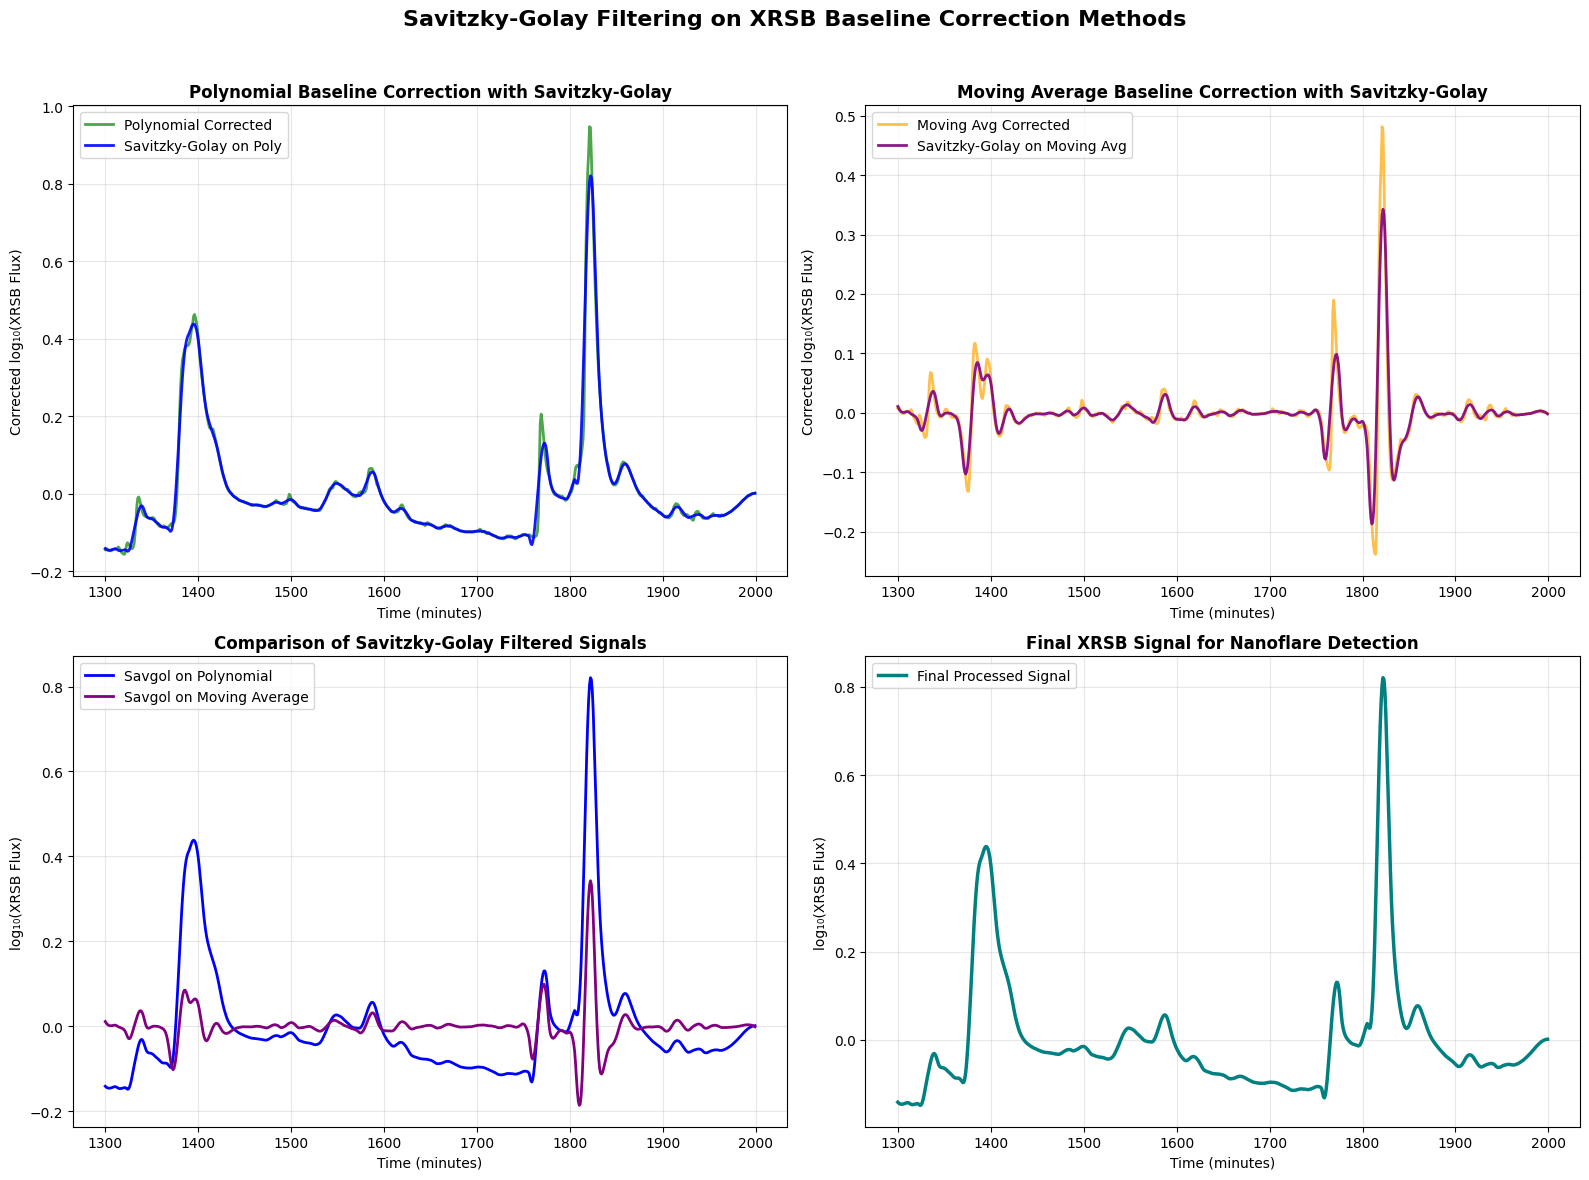

XRSB SAVITZKY-GOLAY FILTERING ANALYSIS:
Filter parameters: Window=21, Order=3
Std Dev (Poly Corrected): 0.146652
Std Dev (Savgol on Poly): 0.143033
Std Dev (Moving Avg Corrected): 0.055559
Std Dev (Savgol on Moving Avg): 0.044529

Final XRSB signal selected from polynomial correction + Savitzky-Golay.


In [72]:
# Savitzky-Golay filter parameters for XRSB
window_length = 21  # Must be odd, controls smoothing
polyorder = 3       # Polynomial order, should be less than window_length

# Apply Savitzky-Golay filter to both baseline-corrected XRSB signals
log_xrsb_savgol_poly = savgol_filter(log_xrsb_corrected_poly, window_length, polyorder)
log_xrsb_savgol_moving = savgol_filter(log_xrsb_corrected_moving, window_length, polyorder)

# Create visualization comparing the results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Savitzky-Golay Filtering on XRSB Baseline Correction Methods', fontsize=16, fontweight='bold')

# Plot 1: Polynomial Correction + Savitzky-Golay
axes[0, 0].plot(time_minutes, log_xrsb_corrected_poly, color='green', linewidth=2, alpha=0.7, label='Polynomial Corrected')
axes[0, 0].plot(time_minutes, log_xrsb_savgol_poly, color='blue', linewidth=2, alpha=0.9, label='Savitzky-Golay on Poly')
axes[0, 0].set_title('Polynomial Baseline Correction with Savitzky-Golay', fontweight='bold')
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Moving Average Correction + Savitzky-Golay
axes[0, 1].plot(time_minutes, log_xrsb_corrected_moving, color='orange', linewidth=2, alpha=0.7, label='Moving Avg Corrected')
axes[0, 1].plot(time_minutes, log_xrsb_savgol_moving, color='purple', linewidth=2, alpha=0.9, label='Savitzky-Golay on Moving Avg')
axes[0, 1].set_title('Moving Average Baseline Correction with Savitzky-Golay', fontweight='bold')
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Corrected log₁₀(XRSB Flux)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Comparison of the two Savitzky-Golay filtered signals
axes[1, 0].plot(time_minutes, log_xrsb_savgol_poly, color='blue', linewidth=2, label='Savgol on Polynomial')
axes[1, 0].plot(time_minutes, log_xrsb_savgol_moving, color='purple', linewidth=2, label='Savgol on Moving Average')
axes[1, 0].set_title('Comparison of Savitzky-Golay Filtered Signals', fontweight='bold')
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('log₁₀(XRSB Flux)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Final selected signal for analysis
# We choose the polynomial-based result as it appears more stable
log_xrsb_final = log_xrsb_savgol_poly
axes[1, 1].plot(time_minutes, log_xrsb_final, color='teal', linewidth=2.5, label='Final Processed Signal')
axes[1, 1].set_title('Final XRSB Signal for Nanoflare Detection', fontweight='bold')
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('log₁₀(XRSB Flux)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print statistics
print("XRSB SAVITZKY-GOLAY FILTERING ANALYSIS:")
print("="*50)
print(f"Filter parameters: Window={window_length}, Order={polyorder}")
print(f"Std Dev (Poly Corrected): {np.std(log_xrsb_corrected_poly):.6f}")
print(f"Std Dev (Savgol on Poly): {np.std(log_xrsb_savgol_poly):.6f}")
print(f"Std Dev (Moving Avg Corrected): {np.std(log_xrsb_corrected_moving):.6f}")
print(f"Std Dev (Savgol on Moving Avg): {np.std(log_xrsb_savgol_moving):.6f}")
print("\nFinal XRSB signal selected from polynomial correction + Savitzky-Golay.")

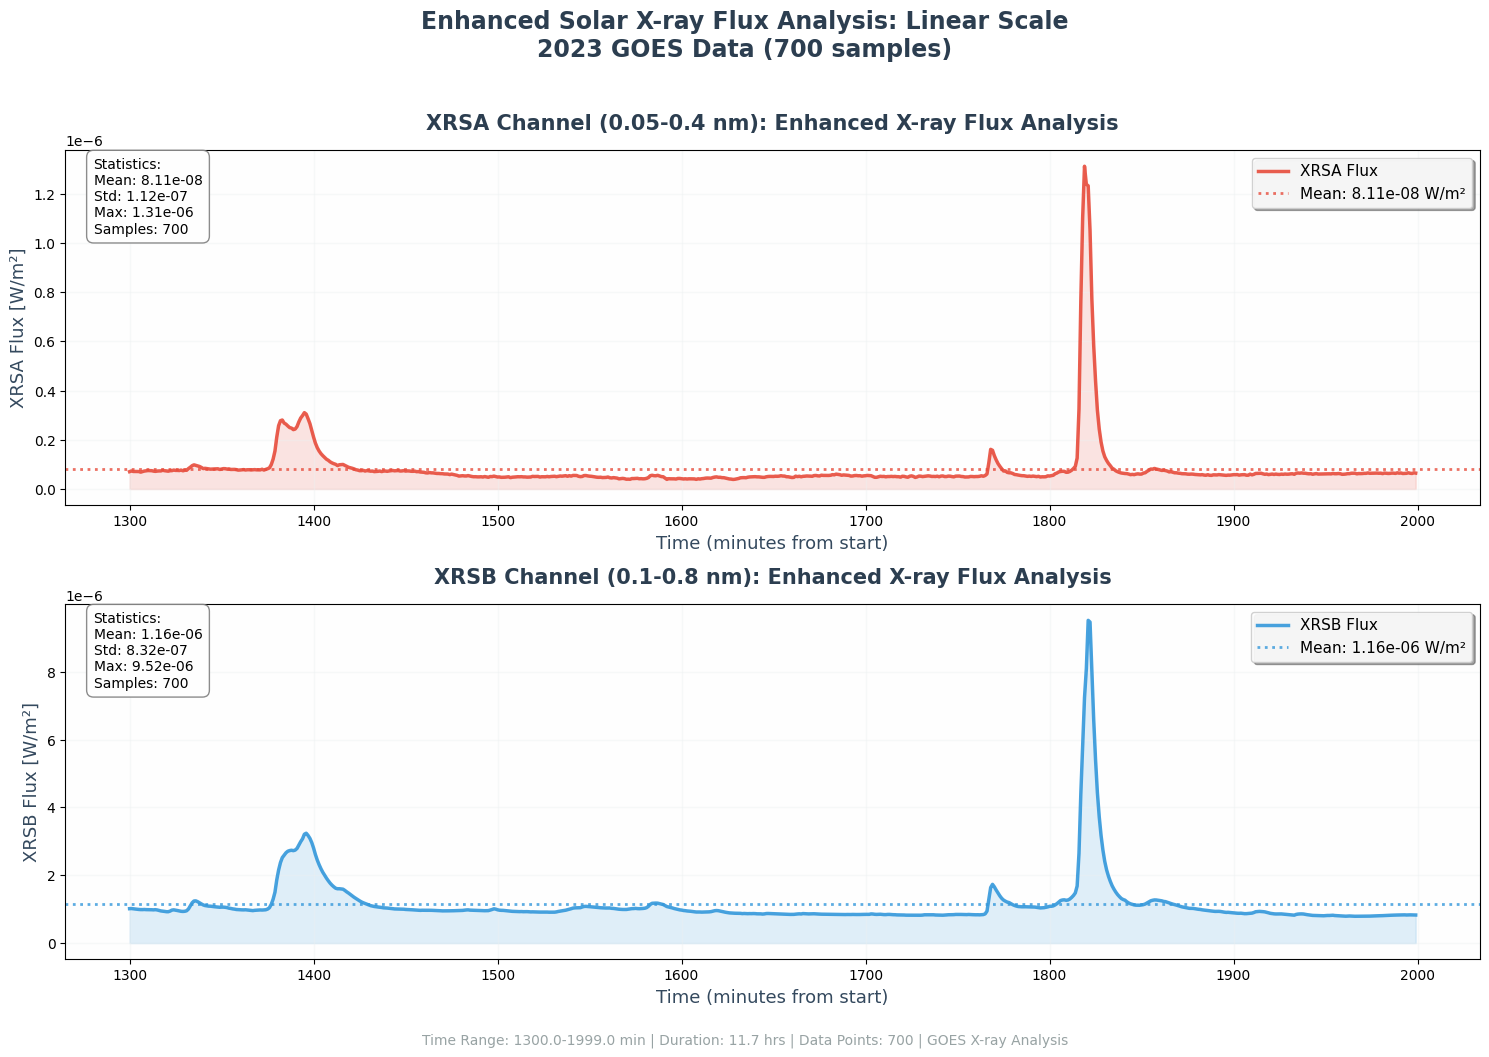

🌟 ENHANCED LINEAR SCALE FLUX VISUALIZATION COMPLETED 🌟
📊 Dataset Overview:
   • Total data points: 700
   • Time span: 699.0 minutes (11.7 hours)
   • Sampling rate: 1.0 minutes/point

📈 XRSA Channel Analysis:
   • Mean flux: 8.108e-08 W/m²
   • Standard deviation: 1.123e-07 W/m²
   • Peak flux: 1.313e-06 W/m²
   • Variability: 138.53%

📉 XRSB Channel Analysis:
   • Mean flux: 1.155e-06 W/m²
   • Standard deviation: 8.318e-07 W/m²
   • Peak flux: 9.515e-06 W/m²
   • Variability: 72.02%

🔗 Cross-Channel Comparison:
   • XRSB/XRSA flux ratio: 14.25
   • Correlation coefficient: 0.9383


In [36]:
# Create enhanced linear scale flux vs time plots with improved styling
plt.style.use('default')  # Reset for custom styling
fig, axes = plt.subplots(2, 1, figsize=(15, 11))

# Set figure background and styling
fig.patch.set_facecolor('white')
fig.suptitle('Enhanced Solar X-ray Flux Analysis: Linear Scale\n2023 GOES Data (700 samples)', 
             fontsize=17, fontweight='bold', y=0.95, color='#2c3e50')

# Calculate statistics for annotations
xrsa_mean = np.mean(xrsa_flux)
xrsa_std = np.std(xrsa_flux)
xrsb_mean = np.mean(xrsb_flux)
xrsb_std = np.std(xrsb_flux)

# Define enhanced color scheme
colors = {
    'xrsa_line': '#e74c3c',
    'xrsa_fill': '#fadbd8',
    'xrsb_line': '#3498db', 
    'xrsb_fill': '#d6eaf8',
    'grid': '#ecf0f1',
    'bg': '#fefefe'
}

# Plot 1: Enhanced XRSA flux vs time
# Line plot with gradient effect
sns.lineplot(x=time_minutes, y=xrsa_flux, ax=axes[0], 
             color=colors['xrsa_line'], linewidth=2.5, alpha=0.9, label='XRSA Flux')

# Add subtle fill area
axes[0].fill_between(time_minutes, xrsa_flux, alpha=0.15, color=colors['xrsa_line'])

# Add mean line with annotation
axes[0].axhline(y=xrsa_mean, color=colors['xrsa_line'], linestyle=':', 
                alpha=0.8, linewidth=2, label=f'Mean: {xrsa_mean:.2e} W/m²')

# Enhanced styling
axes[0].set_title('XRSA Channel (0.05-0.4 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
axes[0].set_xlabel('Time (minutes from start)', fontsize=13, color='#34495e')
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=13, color='#34495e')
axes[0].grid(True, alpha=0.4, color=colors['grid'], linewidth=1, linestyle='-')
axes[0].set_facecolor(colors['bg'])
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Enhanced legend
axes[0].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.9)

# Add statistics text box
stats_text = f'Statistics:\nMean: {xrsa_mean:.2e}\nStd: {xrsa_std:.2e}\nMax: {np.max(xrsa_flux):.2e}\nSamples: {len(xrsa_flux)}'
axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='white', alpha=0.9, edgecolor='gray'))

# Plot 2: Enhanced XRSB flux vs time  
# Line plot with gradient effect
sns.lineplot(x=time_minutes, y=xrsb_flux, ax=axes[1], 
             color=colors['xrsb_line'], linewidth=2.5, alpha=0.9, label='XRSB Flux')

# Add subtle fill area
axes[1].fill_between(time_minutes, xrsb_flux, alpha=0.15, color=colors['xrsb_line'])

# Add mean line with annotation
axes[1].axhline(y=xrsb_mean, color=colors['xrsb_line'], linestyle=':', 
                alpha=0.8, linewidth=2, label=f'Mean: {xrsb_mean:.2e} W/m²')

# Enhanced styling
axes[1].set_title('XRSB Channel (0.1-0.8 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
axes[1].set_xlabel('Time (minutes from start)', fontsize=13, color='#34495e')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=13, color='#34495e')
axes[1].grid(True, alpha=0.4, color=colors['grid'], linewidth=1, linestyle='-')
axes[1].set_facecolor(colors['bg'])
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Enhanced legend
axes[1].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.9)

# Add statistics text box
stats_text = f'Statistics:\nMean: {xrsb_mean:.2e}\nStd: {xrsb_std:.2e}\nMax: {np.max(xrsb_flux):.2e}\nSamples: {len(xrsb_flux)}'
axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='white', alpha=0.9, edgecolor='gray'))

# Improved layout and spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

# Add footer with metadata
fig.text(0.5, 0.01, f'Time Range: {time_minutes[0]:.1f}-{time_minutes[-1]:.1f} min | '
                    f'Duration: {(time_minutes[-1] - time_minutes[0])/60:.1f} hrs | '
                    f'Data Points: {len(time_minutes)} | GOES X-ray Analysis',
         ha='center', fontsize=10, color='#7f8c8d', alpha=0.8)

plt.show()

# Enhanced summary output
print("🌟 ENHANCED LINEAR SCALE FLUX VISUALIZATION COMPLETED 🌟")
print("=" * 65)
print(f"📊 Dataset Overview:")
print(f"   • Total data points: {len(time_minutes)}")
print(f"   • Time span: {time_minutes[-1] - time_minutes[0]:.1f} minutes ({(time_minutes[-1] - time_minutes[0])/60:.1f} hours)")
print(f"   • Sampling rate: {time_minutes[1] - time_minutes[0]:.1f} minutes/point")
print()
print(f"📈 XRSA Channel Analysis:")
print(f"   • Mean flux: {xrsa_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsa_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsa_flux):.3e} W/m²")
print(f"   • Variability: {(xrsa_std/xrsa_mean)*100:.2f}%")
print()
print(f"📉 XRSB Channel Analysis:")
print(f"   • Mean flux: {xrsb_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsb_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsb_flux):.3e} W/m²")
print(f"   • Variability: {(xrsb_std/xrsb_mean)*100:.2f}%")
print()
print(f"🔗 Cross-Channel Comparison:")
print(f"   • XRSB/XRSA flux ratio: {xrsb_mean/xrsa_mean:.2f}")
print(f"   • Correlation coefficient: {np.corrcoef(xrsa_flux, xrsb_flux)[0,1]:.4f}")
print("=" * 65)

Full dataset contains 509419 samples
Time range: 0.0 to 525599.0 minutes
Total observation time: 8760.0 hours
Time range in days: 0.00 to 365.00 days
Total observation time: 365.0 days


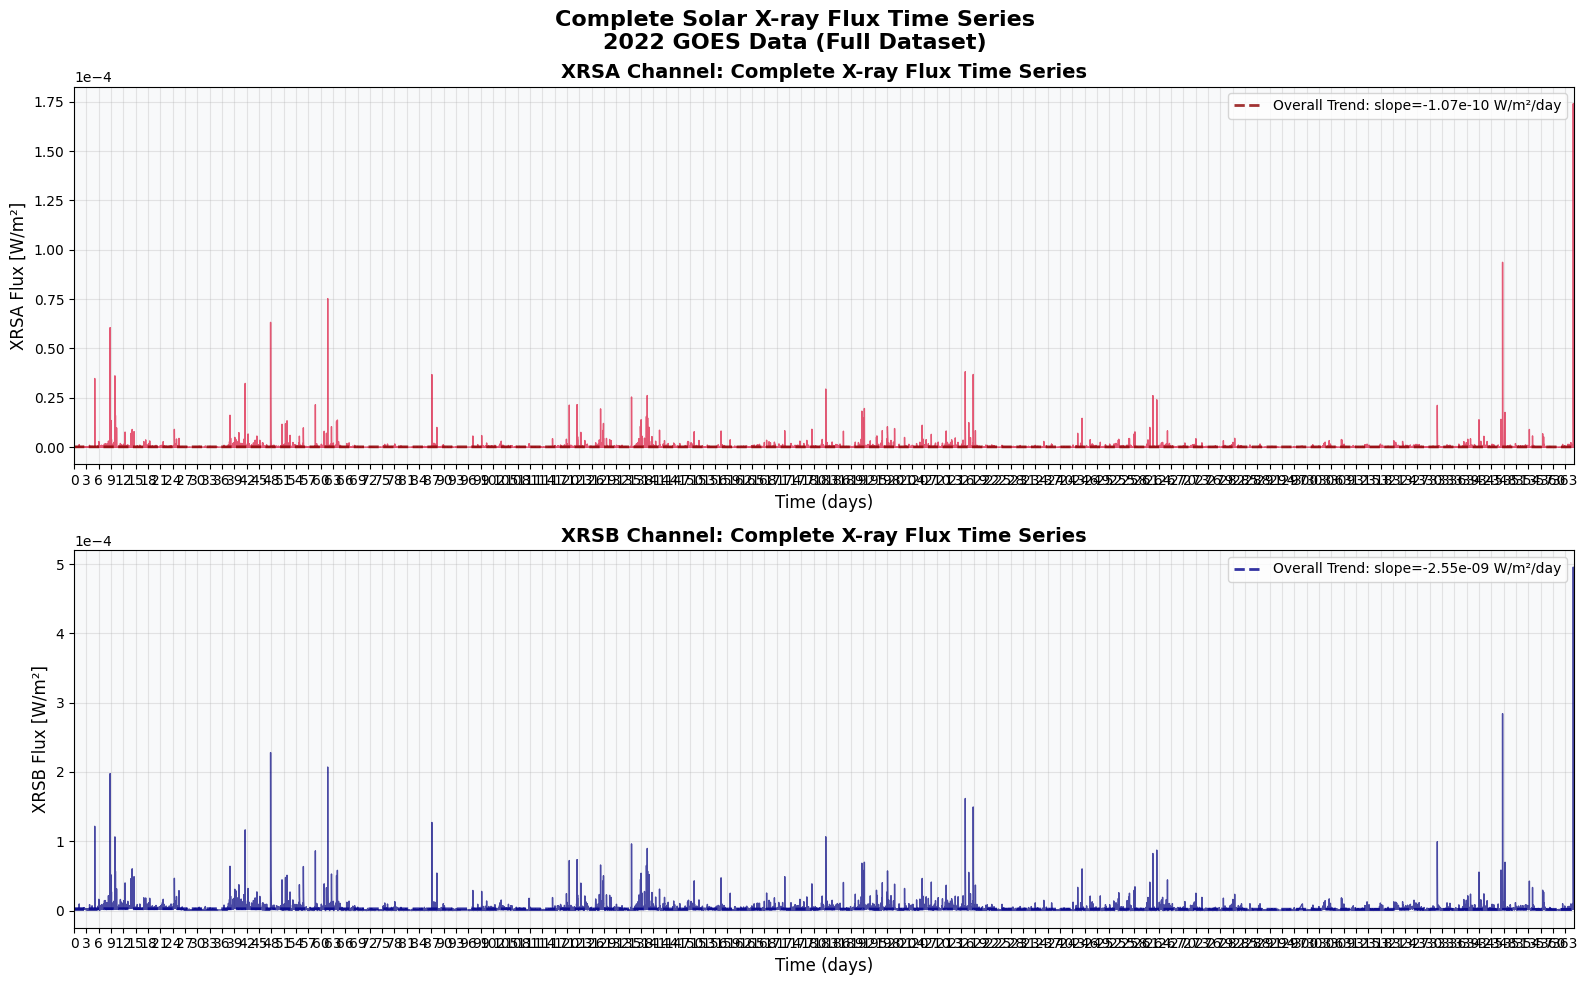

Full dataset visualization created successfully!
Full XRSA trend slope: -1.07e-10 W/m²/day
Full XRSB trend slope: -2.55e-09 W/m²/day
XRSA flux statistics - Mean: 1.46e-07, Std: 1.21e-06
XRSB flux statistics - Mean: 2.23e-06, Std: 5.10e-06


In [37]:
# Plot full dataset without truncation
print(f"Full dataset contains {len(df_clean)} samples")
print(f"Time range: {df_clean['time_minutes'].min():.1f} to {df_clean['time_minutes'].max():.1f} minutes")
print(f"Total observation time: {(df_clean['time_minutes'].max() - df_clean['time_minutes'].min())/60:.1f} hours")

# Extract full dataset
full_time_minutes = df_clean['time_minutes'].values
full_xrsa_flux = df_clean['xrsa_flux_observed'].values
full_xrsb_flux = df_clean['xrsb_flux_observed'].values

# Convert time from minutes to days (1 day = 24*60 = 1440 minutes)
full_time_days = full_time_minutes / 1440
print(f"Time range in days: {full_time_days.min():.2f} to {full_time_days.max():.2f} days")
print(f"Total observation time: {full_time_days.max() - full_time_days.min():.1f} days")

# Create full dataset visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Complete Solar X-ray Flux Time Series\n2022 GOES Data (Full Dataset)', 
             fontsize=16, fontweight='bold')

# Plot 1: Full XRSA flux vs time
sns.lineplot(x=full_time_days, y=full_xrsa_flux, ax=axes[0], 
             color='crimson', linewidth=1, alpha=0.7)
axes[0].set_title('XRSA Channel: Complete X-ray Flux Time Series', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (days)', fontsize=12)
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Set x-axis ticks every 3 days
max_days = full_time_days.max()
day_ticks = np.arange(0, max_days + 3, 3)
axes[0].set_xticks(day_ticks)
axes[0].set_xlim(full_time_days.min(), full_time_days.max())

# Add overall trend line for full XRSA
z_xrsa_full = np.polyfit(full_time_days, full_xrsa_flux, 1)
p_xrsa_full = np.poly1d(z_xrsa_full)
axes[0].plot(full_time_days, p_xrsa_full(full_time_days), '--', 
             color='darkred', alpha=0.8, linewidth=2, 
             label=f'Overall Trend: slope={z_xrsa_full[0]:.2e} W/m²/day')
axes[0].legend()

# Plot 2: Full XRSB flux vs time
sns.lineplot(x=full_time_days, y=full_xrsb_flux, ax=axes[1], 
             color='navy', linewidth=1, alpha=0.7)
axes[1].set_title('XRSB Channel: Complete X-ray Flux Time Series', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (days)', fontsize=12)
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Set x-axis ticks every 3 days
axes[1].set_xticks(day_ticks)
axes[1].set_xlim(full_time_days.min(), full_time_days.max())

# Add overall trend line for full XRSB
z_xrsb_full = np.polyfit(full_time_days, full_xrsb_flux, 1)
p_xrsb_full = np.poly1d(z_xrsb_full)
axes[1].plot(full_time_days, p_xrsb_full(full_time_days), '--', 
             color='darkblue', alpha=0.8, linewidth=2, 
             label=f'Overall Trend: slope={z_xrsb_full[0]:.2e} W/m²/day')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Full dataset visualization created successfully!")
print(f"Full XRSA trend slope: {z_xrsa_full[0]:.2e} W/m²/day")
print(f"Full XRSB trend slope: {z_xrsb_full[0]:.2e} W/m²/day")
print(f"XRSA flux statistics - Mean: {np.mean(full_xrsa_flux):.2e}, Std: {np.std(full_xrsa_flux):.2e}")
print(f"XRSB flux statistics - Mean: {np.mean(full_xrsb_flux):.2e}, Std: {np.std(full_xrsb_flux):.2e}")

Plotting first 100 days of data.
Data points in this range: 137292


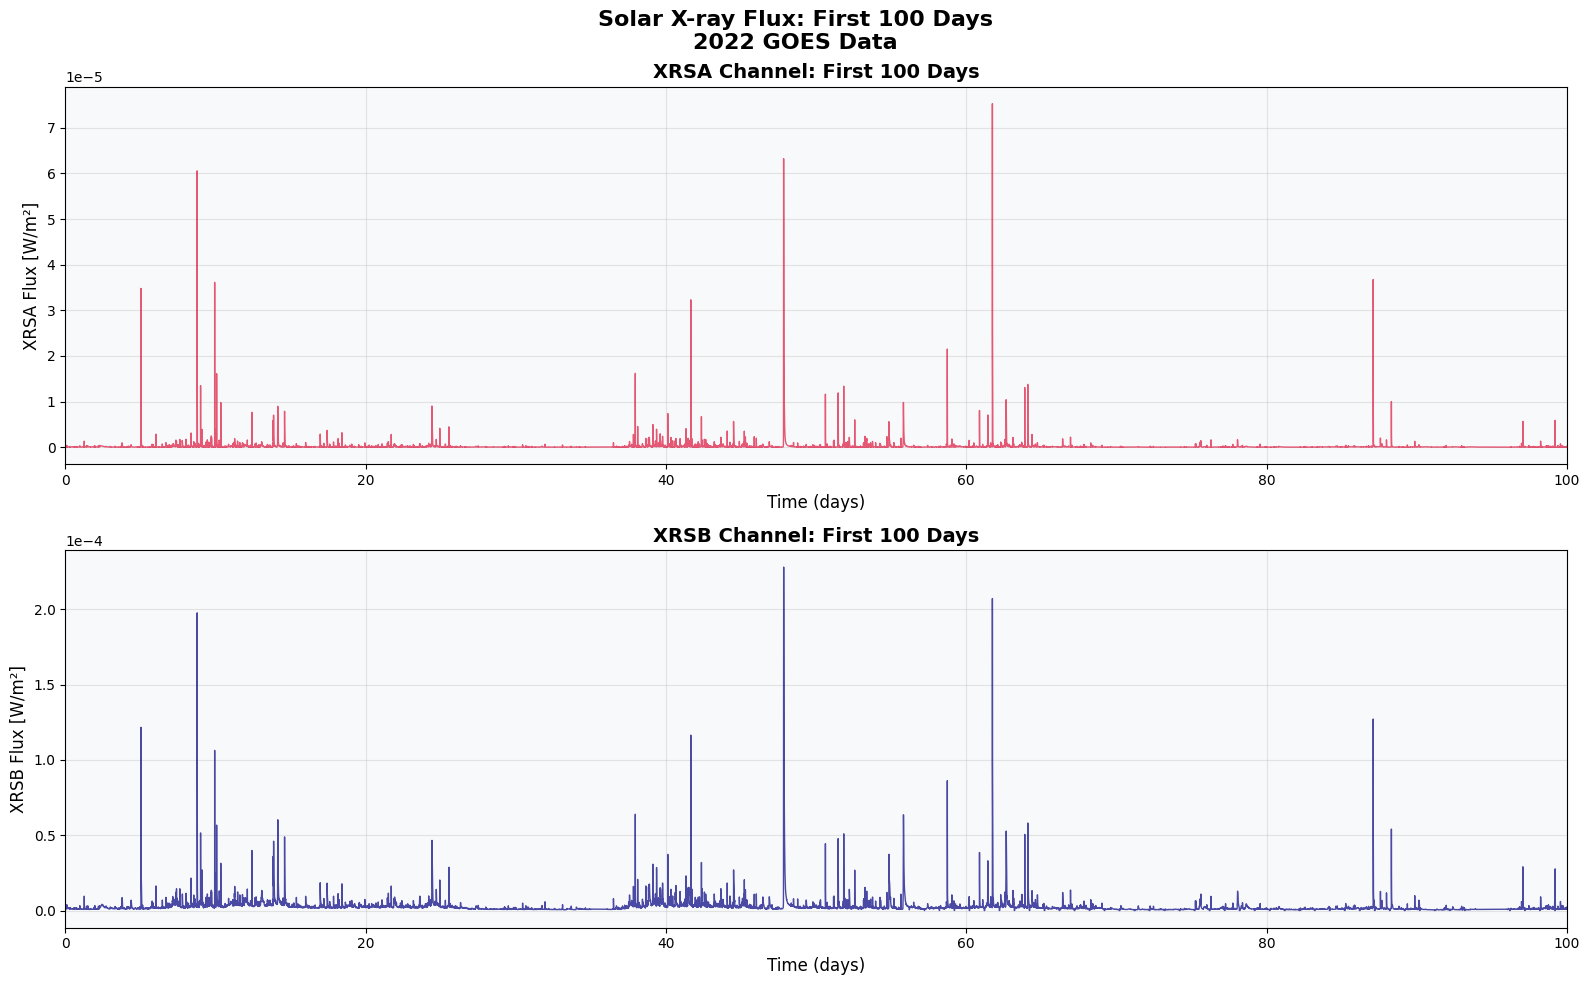

Successfully plotted the first 100 days of flux data.


In [38]:
# Filter data for the first 100 days
days_to_plot = 100
df_100_days = df_clean[df_clean['time_minutes'] <= days_to_plot * 1440].copy()

# Extract data for plotting
time_100_days = df_100_days['time_minutes'].values / 1440
xrsa_100_days = df_100_days['xrsa_flux_observed'].values
xrsb_100_days = df_100_days['xrsb_flux_observed'].values

print(f"Plotting first {days_to_plot} days of data.")
print(f"Data points in this range: {len(df_100_days)}")

# Create 100-day visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle(f'Solar X-ray Flux: First {days_to_plot} Days\n2022 GOES Data', 
             fontsize=16, fontweight='bold')

# Plot 1: XRSA flux for 100 days
sns.lineplot(x=time_100_days, y=xrsa_100_days, ax=axes[0], 
             color='crimson', linewidth=1, alpha=0.7)
axes[0].set_title('XRSA Channel: First 100 Days', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (days)', fontsize=12)
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[0].set_xlim(0, days_to_plot)

# Plot 2: XRSB flux for 100 days
sns.lineplot(x=time_100_days, y=xrsb_100_days, ax=axes[1], 
             color='navy', linewidth=1, alpha=0.7)
axes[1].set_title('XRSB Channel: First 100 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (days)', fontsize=12)
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[1].set_xlim(0, days_to_plot)

plt.tight_layout()
plt.show()

print(f"Successfully plotted the first {days_to_plot} days of flux data.")

In [39]:
# Curve fitting for nanoflare detection
# Define exponential decay function for flare fitting
def exponential_decay(t, A, tau, C):
    """Exponential decay model: A * exp(-t/tau) + C"""
    return A * np.exp(-t / tau) + C

def gaussian_peak(t, A, mu, sigma, C):
    """Gaussian peak model for flare events"""
    return A * np.exp(-0.5 * ((t - mu) / sigma)**2) + C

# Use truncated data from earlier cells (200 samples as originally intended)
# time_minutes, log_xrsa, and log_xrsb are already defined for 200 samples

# Calculate linear trends for detrending
p_xrsa = np.poly1d(np.polyfit(time_minutes, log_xrsa, 1))
p_xrsb = np.poly1d(np.polyfit(time_minutes, log_xrsb, 1))

# Detrend the data to better identify nanoflares
xrsa_detrended = log_xrsa - p_xrsa(time_minutes)
xrsb_detrended = log_xrsb - p_xrsb(time_minutes)

print(f"Using truncated dataset: {len(time_minutes)} samples")
print(f"Time range: {time_minutes[0]:.1f} to {time_minutes[-1]:.1f} minutes")
print(f"XRSA detrended std: {np.std(xrsa_detrended):.6f}")
print(f"XRSB detrended std: {np.std(xrsb_detrended):.6f}")

Using truncated dataset: 700 samples
Time range: 1300.0 to 1999.0 minutes
XRSA detrended std: 0.203661
XRSB detrended std: 0.149344


In [40]:
# --- Advanced Nanoflare Detection: Detailed Explanation ---
# This cell implements a common signal processing technique to identify small, rapid bursts (nanoflares)
# in the solar X-ray flux data. The core idea is to separate the "background" signal from the "event" signal.

# --- Step 1: Signal Smoothing to Isolate the Baseline ---
# Physics: The slowly varying component of the X-ray flux represents the quasi-steady coronal heating and large-scale magnetic evolution.
# Nanoflares are rapid, transient bursts superimposed on this baseline. Smoothing helps separate these two components.
# Math: We apply a Gaussian filter, which is a convolution operation. The filter's weights are determined by a Gaussian function.
# This effectively computes a weighted average for each point, giving more weight to nearby points, thus smoothing the signal.
from scipy.ndimage import gaussian_filter1d

# The 'sigma' parameter controls the width of the Gaussian kernel. A larger sigma results in more smoothing.
sigma_smooth = 2.0  # Defines the standard deviation of the Gaussian kernel in terms of data points.
                     # A value of 2.0 provides moderate smoothing, effective for removing high-frequency noise without distorting larger flare shapes.

# Apply the Gaussian filter to the detrended XRSA signal.
# 'xrsa_detrended' is the signal with the long-term linear trend removed.
# 'xrsa_smooth' will represent the estimated baseline of the detrended signal.
xrsa_smooth = gaussian_filter1d(xrsa_detrended, sigma=sigma_smooth)

# Apply the same Gaussian filter to the detrended XRSB signal.
xrsb_smooth = gaussian_filter1d(xrsb_detrended, sigma=sigma_smooth)


# --- Step 2: Calculate Residuals to Isolate Flare Signatures ---
# Physics: The residuals represent the difference between the observed (detrended) flux and the smoothed baseline.
# These residuals should primarily contain the signatures of rapid energy release events like nanoflares and microflares,
# as the slower variations have been removed.
# Math: This is a simple element-wise subtraction: Residuals = Original Signal - Smoothed Signal.
xrsa_residuals = xrsa_detrended - xrsa_smooth
xrsb_residuals = xrsb_detrended - xrsb_smooth
print("First 10 XRSA residuals:", xrsa_residuals[:10])  # Display first 10 residuals for inspection


# --- Step 3: Define a Statistical Threshold for Event Detection ---
# Physics: We assume that the remaining residuals are mostly composed of instrumental and astrophysical noise, which is
# often normally distributed. Significant physical events (nanoflares) will appear as outliers that stand out from this noise.
# Math: The 3-sigma rule is a common statistical heuristic. For a normal distribution, ~99.7% of data points lie within
# three standard deviations (3*sigma) of the mean. By setting our threshold here, we are flagging points that are
# highly unlikely to be random noise fluctuations.
threshold_xrsa = 3 * np.std(xrsa_residuals)
threshold_xrsb = 3 * np.std(xrsb_residuals)

print(f"\nXRSA nanoflare detection threshold (3-sigma): {threshold_xrsa:.6f}")
print(f"XRSB nanoflare detection threshold (3-sigma): {threshold_xrsb:.6f}")


# --- Step 4: Identify and Locate Potential Nanoflare Events ---
# Physics: This step pinpoints the exact moments in time when the flare-like energy bursts exceed our statistical threshold,
# marking them as candidate nanoflare events for further analysis.
# Math: `np.where()` is a powerful NumPy function that returns the indices of array elements where a given condition is True.
# Here, the condition is that the absolute value of the residual is greater than our 3-sigma threshold.
# We take the absolute value to detect both positive and negative spikes, although physical flares are positive flux increases.
xrsa_events = np.where(np.abs(xrsa_residuals) > threshold_xrsa)[0]
xrsb_events = np.where(np.abs(xrsb_residuals) > threshold_xrsb)[0]

# --- Step 5: Report the Findings ---
# This final section provides a summary of the detection results, including the number of events found in each channel
# and the specific times at which they occurred.
print(f"\nPotential XRSA nanoflare events detected: {len(xrsa_events)}")
print(f"Potential XRSB nanoflare events detected: {len(xrsb_events)}")

if len(xrsa_events) > 0:
    # Use the identified indices to look up the corresponding time values from the 'time_minutes' array.
    print(f"XRSA event times (minutes): {time_minutes[xrsa_events]}")
if len(xrsb_events) > 0:
    print(f"XRSB event times (minutes): {time_minutes[xrsb_events]}")

First 10 XRSA residuals: [-6.67956137e-03  1.04268063e-02 -9.12550723e-04 -5.97914597e-05
  1.38574093e-03  6.26330198e-04 -1.61624919e-02 -4.95620440e-03
  3.06994624e-03  5.56822567e-03]

XRSA nanoflare detection threshold (3-sigma): 0.064208
XRSB nanoflare detection threshold (3-sigma): 0.033925

Potential XRSA nanoflare events detected: 14
Potential XRSB nanoflare events detected: 14
XRSA event times (minutes): [1381 1765 1766 1768 1769 1813 1814 1815 1817 1818 1819 1820 1821 1822]
XRSB event times (minutes): [1765 1766 1768 1769 1813 1814 1815 1817 1818 1819 1820 1821 1822 1823]


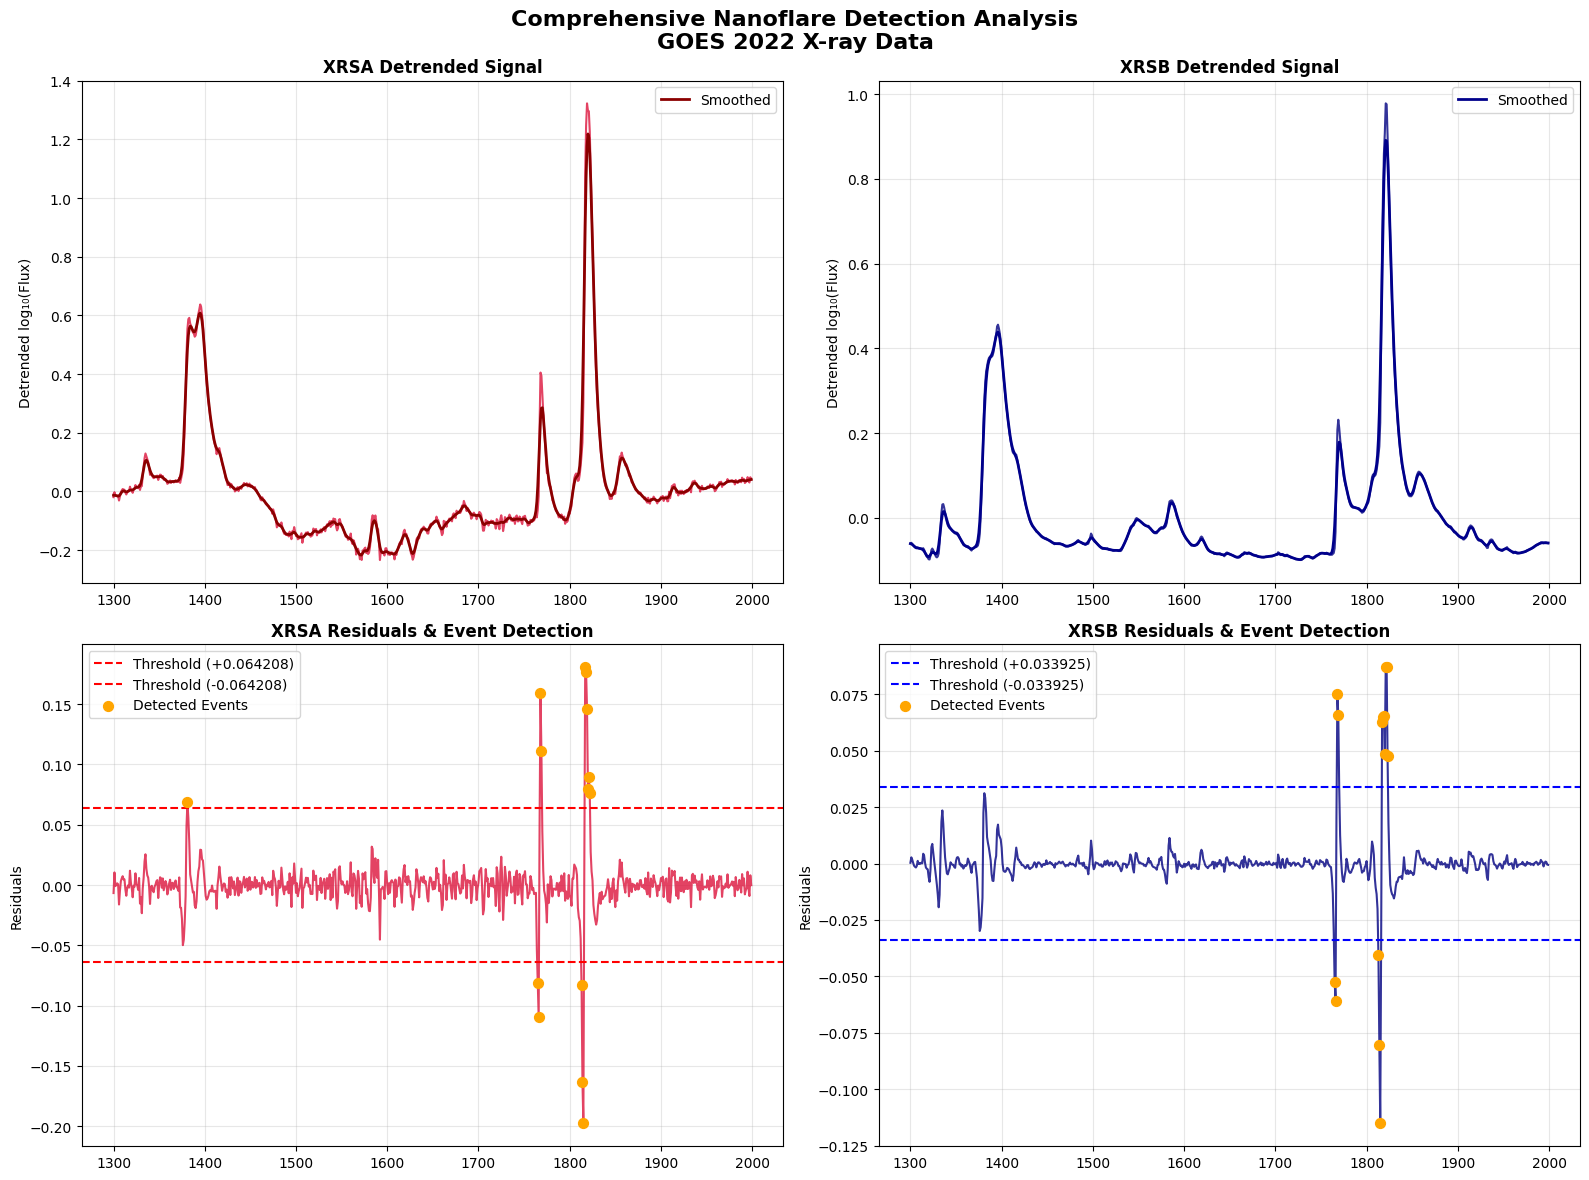

Comprehensive nanoflare detection visualization completed!


In [41]:
# --- Comprehensive Nanoflare Detection Visualization ---
# This cell creates a multi-panel plot to visually summarize the entire nanoflare detection process,
# from the initial detrended signal to the final identified events.

# Create a 2x2 grid of subplots for a comprehensive view. `figsize` is adjusted for clarity.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Set a main title for the entire figure to provide overall context.
fig.suptitle('Comprehensive Nanoflare Detection Analysis\nGOES 2022 X-ray Data', 
             fontsize=16, fontweight='bold')

# --- Top Row: Visualizing the Detrended Signals and their Baselines ---
# These plots show the log-flux after the long-term linear trend has been removed, isolating shorter-term variability.

# Plot 1 (Top-Left): XRSA Detrended Signal
# Physics: This shows the XRSA flux variability, where nanoflares are expected to appear as sharp peaks.
axes[0,0].plot(time_minutes, xrsa_detrended, color='crimson', linewidth=1.5, alpha=0.8, label='Detrended Signal')
# Overlay the smoothed baseline calculated in the previous cell.
# Physics: This line represents the slow-moving background fluctuation that we want to separate from the flares.
axes[0,0].plot(time_minutes, xrsa_smooth, color='darkred', linewidth=2, label='Smoothed Baseline')
axes[0,0].set_title('XRSA Detrended Signal & Baseline', fontweight='bold')
axes[0,0].set_ylabel('Detrended log₁₀(Flux)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Plot 2 (Top-Right): XRSB Detrended Signal
# Physics: This is the same visualization as the one on the left, but for the higher-energy XRSB channel.
axes[0,1].plot(time_minutes, xrsb_detrended, color='navy', linewidth=1.5, alpha=0.8, label='Detrended Signal')
# Overlay the smoothed baseline for the XRSB channel.
axes[0,1].plot(time_minutes, xrsb_smooth, color='darkblue', linewidth=2, label='Smoothed Baseline')
axes[0,1].set_title('XRSB Detrended Signal & Baseline', fontweight='bold')
axes[0,1].set_ylabel('Detrended log₁₀(Flux)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# --- Bottom Row: Visualizing the Residuals and Detected Events ---
# These plots show the result of subtracting the smoothed baseline from the detrended signal, isolating the flare events.

# Plot 3 (Bottom-Left): XRSA Residuals and Event Detection
# Physics: The residuals represent the sharp, transient energy bursts (nanoflares) we are looking for.
axes[1,0].plot(time_minutes, xrsa_residuals, color='crimson', linewidth=1.5, alpha=0.8, label='Residuals')
# Draw the positive 3-sigma threshold line.
# Math: Any point above this line is considered a statistically significant positive fluctuation (a potential flare).
axes[1,0].axhline(y=threshold_xrsa, color='red', linestyle='--', label=f'3σ Threshold (+{threshold_xrsa:.4f})')
# Draw the negative 3-sigma threshold line.
axes[1,0].axhline(y=-threshold_xrsa, color='red', linestyle='--')
# Highlight the detected events with scatter plot markers.
# Physics: These are the specific moments in time where the energy burst was strong enough to cross our detection threshold.
if len(xrsa_events) > 0:
    axes[1,0].scatter(time_minutes[xrsa_events], xrsa_residuals[xrsa_events], 
                      color='orange', s=50, zorder=5, label='Detected Events')
axes[1,0].set_title('XRSA Residuals & Event Detection', fontweight='bold')
axes[1,0].set_ylabel('Residuals (Signal - Baseline)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# Plot 4 (Bottom-Right): XRSB Residuals and Event Detection
# Physics: This is the same analysis for the XRSB channel.
axes[1,1].plot(time_minutes, xrsb_residuals, color='navy', linewidth=1.5, alpha=0.8, label='Residuals')
# Draw the positive 3-sigma threshold line for the XRSB channel.
axes[1,1].axhline(y=threshold_xrsb, color='blue', linestyle='--', label=f'3σ Threshold (+{threshold_xrsb:.4f})')
# Draw the negative 3-sigma threshold line for the XRSB channel.
axes[1,1].axhline(y=-threshold_xrsb, color='blue', linestyle='--')
# Highlight the detected events in the XRSB channel.
if len(xrsb_events) > 0:
    axes[1,1].scatter(time_minutes[xrsb_events], xrsb_residuals[xrsb_events], 
                      color='orange', s=50, zorder=5, label='Detected Events')
axes[1,1].set_title('XRSB Residuals & Event Detection', fontweight='bold')
axes[1,1].set_ylabel('Residuals (Signal - Baseline)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

# Adjust layout to prevent titles and labels from overlapping.
plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect is used to make space for the suptitle

# Display the final plot.
plt.show()

print("Comprehensive nanoflare detection visualization completed!")

In [42]:
# Summary statistics and nanoflare characterization
print("=" * 60)
print("NANOFLARE DETECTION SUMMARY")
print("=" * 60)

print(f"Analysis period: {time_minutes[0]:.1f} - {time_minutes[-1]:.1f} minutes")
print(f"Total samples analyzed: {len(time_minutes)}")
print(f"Sampling interval: {time_minutes[1] - time_minutes[0]:.1f} minutes")

print("\nBASELINE CHARACTERISTICS:")
print(f"XRSA mean flux: {np.mean(xrsa_flux):.3e} W/m²")
print(f"XRSB mean flux: {np.mean(xrsb_flux):.3e} W/m²")
print(f"XRSA variability (std): {np.std(xrsa_detrended):.6f}")
print(f"XRSB variability (std): {np.std(xrsb_detrended):.6f}")

print("\nNANOFLARE DETECTION RESULTS:")
print(f"XRSA events detected: {len(xrsa_events)}")
print(f"XRSB events detected: {len(xrsb_events)}")
print(f"Total unique events: {len(set(list(xrsa_events) + list(xrsb_events)))}")

# Calculate event rate
observation_time_hours = (time_minutes[-1] - time_minutes[0]) / 60
xrsa_event_rate = len(xrsa_events) / observation_time_hours
xrsb_event_rate = len(xrsb_events) / observation_time_hours

print(f"\nEVENT RATES:")
print(f"XRSA event rate: {xrsa_event_rate:.2f} events/hour")
print(f"XRSB event rate: {xrsb_event_rate:.2f} events/hour")

# Energy band ratio analysis for event classification
if len(xrsa_events) > 0 and len(xrsb_events) > 0:
    # Find coincident events (within 2 time steps)
    coincident_events = []
    for xrsa_idx in xrsa_events:
        for xrsb_idx in xrsb_events:
            if abs(xrsa_idx - xrsb_idx) <= 2:
                coincident_events.append((xrsa_idx, xrsb_idx))
    
    print(f"\nCOINCIDENT EVENTS: {len(coincident_events)}")
    if len(coincident_events) > 0:
        print("Potential multi-band nanoflare signatures detected!")

print("\nTECHNICAL NOTES:")
print(f"Detection threshold: 3-sigma criterion")
print(f"Smoothing kernel: Gaussian (σ = {sigma_smooth})")
print(f"Detrending: Linear trend removal")
print("Signal processing: Residual analysis after trend and smoothing removal")

print("\n" + "=" * 60)
print("Analysis completed successfully!")
print("=" * 60)

NANOFLARE DETECTION SUMMARY
Analysis period: 1300.0 - 1999.0 minutes
Total samples analyzed: 700
Sampling interval: 1.0 minutes

BASELINE CHARACTERISTICS:
XRSA mean flux: 8.108e-08 W/m²
XRSB mean flux: 1.155e-06 W/m²
XRSA variability (std): 0.203661
XRSB variability (std): 0.149344

NANOFLARE DETECTION RESULTS:
XRSA events detected: 14
XRSB events detected: 14
Total unique events: 15

EVENT RATES:
XRSA event rate: 1.20 events/hour
XRSB event rate: 1.20 events/hour

COINCIDENT EVENTS: 47
Potential multi-band nanoflare signatures detected!

TECHNICAL NOTES:
Detection threshold: 3-sigma criterion
Smoothing kernel: Gaussian (σ = 2.0)
Detrending: Linear trend removal
Signal processing: Residual analysis after trend and smoothing removal

Analysis completed successfully!


In [43]:
# Create a final summary DataFrame for detected events
if len(xrsa_events) > 0 or len(xrsb_events) > 0:
    event_summary = []
    
    # Add XRSA events
    for idx in xrsa_events:
        event_summary.append({
            'Time_minutes': time_minutes[idx],
            'Channel': 'XRSA',
            'Residual_amplitude': xrsa_residuals[idx],
            'Threshold': threshold_xrsa,
            'Significance': abs(xrsa_residuals[idx]) / threshold_xrsa
        })
    
    # Add XRSB events
    for idx in xrsb_events:
        event_summary.append({
            'Time_minutes': time_minutes[idx],
            'Channel': 'XRSB',
            'Residual_amplitude': xrsb_residuals[idx],
            'Threshold': threshold_xrsb,
            'Significance': abs(xrsb_residuals[idx]) / threshold_xrsb
        })
    
    events_df = pd.DataFrame(event_summary)
    events_df = events_df.sort_values('Time_minutes')
    
    print("DETECTED NANOFLARE EVENTS SUMMARY:")
    print(events_df.to_string(index=False))
    
    # Save results
    events_df.to_csv('nanoflare_events_detected.csv', index=False)
    print("\nResults saved to 'nanoflare_events_detected.csv'")
else:
    print("No nanoflare events detected above the 3-sigma threshold.")
    print("This could indicate either:")
    print("1. Very quiet solar conditions during this period")
    print("2. Nanoflare activity below current detection sensitivity")
    print("3. Need for different analysis parameters or longer observation period")

DETECTED NANOFLARE EVENTS SUMMARY:
 Time_minutes Channel  Residual_amplitude  Threshold  Significance
         1381    XRSA            0.068409   0.064208      1.065420
         1765    XRSA           -0.081573   0.064208      1.270443
         1765    XRSB           -0.052372   0.033925      1.543763
         1766    XRSA           -0.109179   0.064208      1.700388
         1766    XRSB           -0.060847   0.033925      1.793569
         1768    XRSA            0.159558   0.064208      2.485017
         1768    XRSB            0.075010   0.033925      2.211037
         1769    XRSA            0.110822   0.064208      1.725988
         1769    XRSB            0.065885   0.033925      1.942059
         1813    XRSB           -0.040302   0.033925      1.187977
         1813    XRSA           -0.083304   0.064208      1.297403
         1814    XRSA           -0.163622   0.064208      2.548300
         1814    XRSB           -0.080161   0.033925      2.362885
         1815    XRSA      